In [1]:
from keras.layers import Input,Dense,Lambda,Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import warnings 


Using TensorFlow backend.


In [2]:
IMAGE_SIZE = [100,100]
epochs = 5
batch_size = 32

train_path = 'fruits-360-small/Training'
valid_path = 'fruits-360-small/Test'

In [17]:
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [18]:
folders = glob(train_path + '/*')

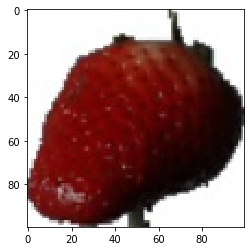

In [6]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [5]:
vgg = VGG16(input_shape = IMAGE_SIZE + [3],weights = 'imagenet',include_top = False)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
for layer in vgg.layers:
    layer.trainable = False

In [7]:
x = Flatten()(vgg.output)

In [8]:
prediction = Dense(len(folders),activation = 'softmax')(x)

In [9]:
model = Model(inputs = vgg.input, outputs = prediction)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [22]:
model.compile(
              loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy']
                 )

In [23]:
gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function = preprocess_input                               
)

In [24]:
test_gen = gen.flow_from_directory(valid_path,target_size = IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None]*len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k

Found 1289 images belonging to 8 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Mango': 5, 'Raspberry': 6, 'Strawberry': 7}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min:  -102.61553 max:  151.061


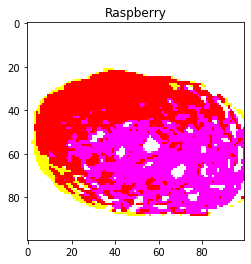

In [25]:
for x,y in test_gen:
    print('min: ',x[0].min(),'max: ',x[0].max()) 
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [26]:
train_generator = gen.flow_from_directory(
train_path,
target_size = IMAGE_SIZE,
shuffle = True,
batch_size = batch_size
)

Found 3839 images belonging to 8 classes.


In [27]:
valid_generator = gen.flow_from_directory(
valid_path,
target_size = IMAGE_SIZE,
shuffle = True,
batch_size = batch_size
)

Found 1289 images belonging to 8 classes.


In [28]:
r = model.fit_generator(
train_generator,
validation_data = valid_generator,
epochs = epochs,
steps_per_epoch = len(image_files )// batch_size,
validation_steps = len(valid_image_files) // batch_size)

Epoch 1/5
119/119 [==============================] - 239s 2s/step - loss: 4.6578 - acc: 0.7033 - val_loss: 4.1401 - val_acc: 0.7422
Epoch 2/5
119/119 [==============================] - 88s 741ms/step - loss: 3.0728 - acc: 0.8046 - val_loss: 2.1109 - val_acc: 0.8663
Epoch 3/5
119/119 [==============================] - 91s 761ms/step - loss: 2.0678 - acc: 0.8692 - val_loss: 2.0754 - val_acc: 0.8703
Epoch 4/5
119/119 [==============================] - 98s 824ms/step - loss: 2.0364 - acc: 0.8734 - val_loss: 2.0832 - val_acc: 0.8703
Epoch 5/5
119/119 [==============================] - 63s 531ms/step - loss: 2.0994 - acc: 0.8687 - val_loss: 2.0526 - val_acc: 0.8719


In [36]:
def get_confusion_matrix(data_path,N):
    
    predictions = []
    targets = []
    i = 0
    for x,y in gen.flow_from_directory(data_path,target_size = IMAGE_SIZE,shuffle = False,batch_size = batch_size*2):
        i += 1
        if i%50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p,axis = 1)
        y = np.argmax(y,axis = 1)
        predictions = np.concatenate((predictions,p))
        targets = np.concatenate((targets,y))
        if len(targets) >= N:
            break
    cm = confusion_matrix(targets,predictions)
    return cm  

In [37]:
cm = get_confusion_matrix(train_path,len(image_files))
print(cm)

Found 3839 images belonging to 8 classes.
50
[[492   0   0   0   0   0   0   0]
 [  0 427   0   0   0   0   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  7 483   0   0   0   0   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]


In [38]:
valid_cm = get_confusion_matrix(valid_path,len(valid_image_files))
print(valid_cm)

Found 1289 images belonging to 8 classes.
[[164   0   0   0   0   0   0   0]
 [  0 143   0   0   0   0   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0 166   0   0   0   0   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


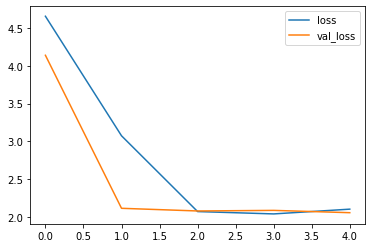

In [39]:
plt.plot(r.history['loss'],label = 'loss')
plt.plot(r.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

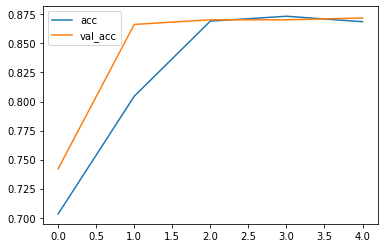

In [45]:
plt.plot(r.history['acc'],label = 'acc')
plt.plot(r.history['val_acc'],label = 'val_acc')
plt.legend()
plt.show()

In [63]:
from util import plot_confusion_matrix

Confusion matrix, without normalization
[[492   0   0   0   0   0   0   0]
 [  0 427   0   0   0   0   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  7 483   0   0   0   0   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]


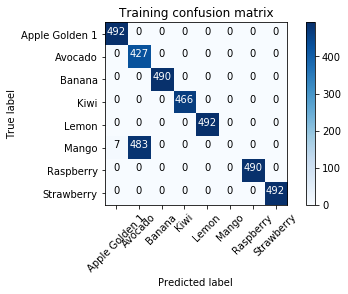

In [64]:
plot_confusion_matrix(cm,labels,title ='Training confusion matrix')

Confusion matrix, without normalization
[[164   0   0   0   0   0   0   0]
 [  0 143   0   0   0   0   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0 166   0   0   0   0   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


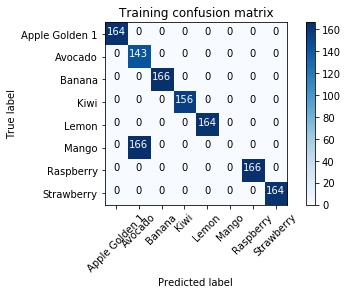

In [65]:
plot_confusion_matrix(valid_cm,labels,title ='Training confusion matrix')